In [1]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import pickle

### Load Data

In [2]:
def read_dataset(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f) #,encoding='latin1'

In [3]:
## read all data into variables 
X,Y,X_max_length,Y_max_length,en_int_to_vocab,en_vocab_to_int,cn_int_to_vocab,cn_vocab_to_int = read_dataset('cn2en.p')

In [4]:
# inspect data
print ('Sentence in English - encoded:', X[2])
print ('Sentence in Chinese - encoded:', Y[2])
print ('Decoded:\n------------------------')

s=""
for i in range(len(X[2])):
    s = s + " " + en_int_to_vocab[X[2][i]]
print(s)

s=""
for i in range(len(Y[2])):
    s = s + " " + cn_int_to_vocab[Y[2][i]]
print (s)

Sentence in English - encoded: [953, 427, 91, 50, 4, 48180, 7362, 5, 4]
Sentence in Chinese - encoded: [12, 175, 5, 564, 526, 127, 443, 394, 30, 1084, 366]
Decoded:
------------------------
 Keep fucking going !  Controlled aggression . 
 他 妈 的 继 续 啊 控 制 好 攻 击


### Data processing

In [5]:
# data padding

def data_padding(x, y, length):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_vocab_to_int['<pad>']]
        y[i] = [cn_vocab_to_int['<go>']] + y[i] + [cn_vocab_to_int['<eos>']] + (length-len(y[i])) * [cn_vocab_to_int['<pad>']]

input_length = min(max(X_max_length,Y_max_length),50)
        
data_padding(X, Y,input_length)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [6]:
# build a model

input_seq_len = input_length
output_seq_len = input_length+2
en_vocab_size = len(en_vocab_to_int)# + 2 # + <pad>, <ukn>
cn_vocab_size = len(cn_vocab_to_int)# + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target')) ## add last, to make it the same as decode input
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

In [7]:
# output projection
size = 512
w_t = tf.get_variable('proj_w', [cn_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [cn_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = cn_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [8]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = cn_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [9]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = cn_vocab_to_int['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == cn_vocab_to_int['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = [cn_int_to_vocab[idx] for idx in output_seq]
    return words
             
# def decode_output(output_seq):
#     words = []
#     for i in range(output_seq_len):
#         smax = softmax(output_seq[i])
#         idx = np.argmax(smax)
#         words.append(cn_vocab_to_int[idx])
#     return words

In [10]:
# ops and hyperparameters
learning_rate = 5e-3
batch_size = 64
steps = 10000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [11]:
# let's train the model

# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print ('------------------TRAINING------------------')

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 200 == 0 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
        
        if step % 1000 == 0:
            saver.save(sess, 'checkpoints/', global_step=step)
            print ('Checkpoint is saved')
            
    print ('Training time for {} steps: {}s'.format(steps, time.time() - t))

------------------TRAINING------------------
step: 0, loss: 8.049732208251953
Checkpoint is saved
step: 200, loss: 5.007501602172852
step: 400, loss: 3.7146365642547607
step: 600, loss: 3.265096664428711
step: 800, loss: 2.882694721221924
step: 1000, loss: 2.8592934608459473
Checkpoint is saved
step: 1200, loss: 2.3907723426818848
step: 1400, loss: 2.3186521530151367
step: 1600, loss: 2.5496885776519775
step: 1800, loss: 2.2948598861694336
step: 2000, loss: 2.4860246181488037
Checkpoint is saved
step: 2200, loss: 2.0967469215393066
step: 2400, loss: 2.227423667907715
step: 2600, loss: 2.133627414703369
step: 2800, loss: 2.00405216217041
step: 3000, loss: 2.1269402503967285
Checkpoint is saved
step: 3200, loss: 1.748936653137207
step: 3400, loss: 1.9100935459136963
step: 3600, loss: 1.874370813369751
step: 3800, loss: 1.7887767553329468
step: 4000, loss: 1.7585563659667969
Checkpoint is saved
step: 4200, loss: 1.7264553308486938
step: 4400, loss: 1.8747832775115967
step: 4600, loss: 1.7

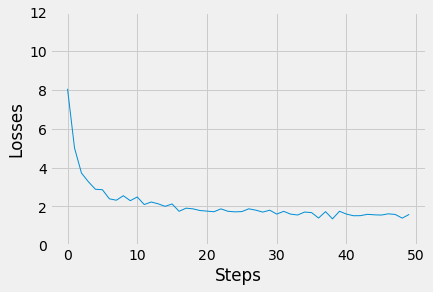

In [12]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((0, 12))

plt.show()

In [15]:
# let's test the model

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [cn_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [cn_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = cn_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences     
    en_sentences = ["What' s your name", 'what is going on? I have no idea.','My name is', 'What are you doing', 'I am reading a book',\
                    'How are you?', 'I am good', 'Do you speak English', 'What time is it', 'Hi', 'Goodbye', 'Yes', 'No']
    en_sentences_encoded = [[en_vocab_to_int.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]

    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (input_seq_len - len(en_sentences_encoded[i])) * [en_vocab_to_int['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpoints')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([cn_vocab_to_int['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        output_predicts = np.argmax(np.array(output_sequences).transpose(1,0,2),2)
        
        # decode seq.
        for i in range(len(output_predicts)):
            print ('{}.\n--------------------------------'.format(i+1))
            ouput_seq = output_predicts[i,:]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print (en_sentences[i])
            chinese_words =''
            for i in range(len(words)):
                if words[i] not in ['<eos>', '<pad>', '<go>']:
                    chinese_words+=words[i]
            print(chinese_words)
            print ('\n--------------------------------')

1.
--------------------------------
What' s your name
你叫我的名叫

--------------------------------
2.
--------------------------------
what is going on? I have no idea.
我不是什么意思

--------------------------------
3.
--------------------------------
My name is
我的名叫

--------------------------------
4.
--------------------------------
What are you doing
你在干什么

--------------------------------
5.
--------------------------------
I am reading a book
我很读急

--------------------------------
6.
--------------------------------
How are you?
你们怎么样

--------------------------------
7.
--------------------------------
I am good
我很好

--------------------------------
8.
--------------------------------
Do you speak English
你说英雄

--------------------------------
9.
--------------------------------
What time is it
我们的时间

--------------------------------
10.
--------------------------------
Hi
你们

--------------------------------
11.
--------------------------------
Goodbye
你们的情况

---------------------------

# This model can be improved by using more training steps, better dataset or even with better selection of hyperparameters 